In [115]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

In [116]:
data_dir = './input_data/max_vanatta_direct_heat_anrs'

# Merge all data

In [117]:
ercot_no_cogen = pd.read_csv(os.path.join(data_dir,'ERCOT_0_BestPair.csv'))
ercot_no_cogen = ercot_no_cogen.iloc[:,2:]
ercot_no_cogen['cogen'] = False
ercot_no_cogen['region'] = 'ERCOT'
ercot_cogen = pd.read_csv(os.path.join(data_dir, 'ERCOT_2020_BestPair.csv'))
ercot_cogen = ercot_cogen.iloc[:,2:]
ercot_cogen['cogen'] = True
ercot_cogen['region'] = 'ERCOT'

spp_cogen = pd.read_csv(os.path.join(data_dir, 'SPP_2021_BestPair.csv'))
spp_cogen = spp_cogen.iloc[:,2:]
spp_cogen['cogen'] =True
spp_cogen['region'] = 'SPP'

In [118]:
# 
spp_no_cogen = pd.read_csv(os.path.join(data_dir, 'SPP_0_PerFacility.csv'))
spp_no_cogen = spp_no_cogen.iloc[:,2:]
spp_no_cogen['cogen'] = False 
spp_no_cogen['region'] = 'SPP'
# Select ANR design corresponding to max profit
idx = spp_no_cogen.groupby('Facility ID')['Profit'].idxmax()
max_profit = spp_no_cogen.loc[idx]
spp_no_cogen = max_profit

In [119]:
input_data = pd.read_csv(os.path.join(data_dir, 'Thermal_Demands.csv'))
input_data = input_data[['FACILITY_ID', 'STATE', 'Temp_degC']]


In [120]:
# Merge everything
heat_df = pd.concat([ercot_no_cogen, ercot_cogen, spp_no_cogen, spp_cogen])
heat_df = heat_df.merge(input_data,left_on='Facility ID', right_on='FACILITY_ID')
heat_df.head(3)

,LMPType,Facility ID,Temperature Req,Generator,Modules,Facility Demand,Profit,Annualized Capital Cost,Fixed Cost,Variable Cost,...,Start-Up Cost,Electric Wholesale Revenues,Industry,NGBE_Cost,Energy Breakeven Price [$/GJ],cogen,region,FACILITY_ID,STATE,Temp_degC
0,ERCOT_2020_HubAVG.csv,1005344,180,Microreactor,1,7.722651,-7660649.708,-5886288.708,-1771011,0.0,...,-3350.0,0.0000,Iron and Steel Mills,27.384599,31.455211,False,ERCOT,1005344,TX,1100
1,ERCOT_2020_HubAVG.csv,1005344,180,Microreactor,1,7.722651,-7660649.708,-5886288.708,-1771011,0.0,...,-3350.0,0.0000,Iron and Steel Mills,27.384599,31.455211,False,ERCOT,1005344,TX,180
2,ERCOT_2020_HubAVG.csv,1005344,180,Microreactor,1,7.722651,-6942918.776,-5886288.708,-1771011,0.0,...,-3350.0,717730.9325,Iron and Steel Mills,24.818919,28.508154,True,ERCOT,1005344,TX,1100


In [121]:
heat_df.rename(columns={'NGBE_Cost': 'Breakeven price ($/MMBtu)'}, inplace=True)

# State level price data

In [122]:
# state-level natural gas prices
state_ng = pd.read_excel('./input_data/ng_prices_state_annual_us.xlsx', sheet_name='clean_data_2022', header=0 ).transpose()
state_ng.reset_index(inplace=True)
state_ng.rename(columns={0:'NG price ($/MMBtu)', 'index':'state'}, inplace=True)
state_ng['state'] = state_ng.apply(lambda x:x['state'].split(' Natural')[0], axis=1)
state_ng.set_index('state', inplace=True)
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}
abbrev_states = pd.DataFrame(us_state_to_abbrev.items(), columns=['state', 'abbrev'])
abbrev_states.set_index('state', inplace=True)
state_ng = state_ng.merge(abbrev_states, on='state')
state_ng.reset_index(inplace=True)
state_ng.head(2)

,state,NG price ($/MMBtu),abbrev
0,Alabama,7.87,AL
1,Alaska,6.72,AK


In [123]:
heat_df = heat_df.merge(state_ng, left_on='STATE', right_on='abbrev')
heat_df.rename(columns = {'NG price ($/MMBtu)': 'State-level price ($/MMBtu)'}, inplace=True)
heat_df = heat_df[heat_df['Energy Breakeven Price [$/GJ]'] != np.inf]

In [124]:
# Combine industries
heat_df.replace({'Paperboard Mills':'Paper Mills', 'Paper Mills, except Newsprint': 'Paper Mills',
                  'Petrochemicals': 'Petro- and organic chemicals', 'Other Basic Organic Chemicals': 'Petro- and organic chemicals'}, inplace=True)

# Compute Net Annual Revenues

In [125]:
# Net Revenues = Profit + Revenues from process heat
# Facility Demand in average MWt per year  so multiply by 265*24 for MWh-t per year and 
MWh_to_mmbtu = 3.412 #MMBtu/MWh
# Price US NG 2021 or state-level pricess
ng_price_us_2021 = 4 #$/MMBtu
heat_df['NatGCost_multiplier'] = MWh_to_mmbtu/(-0.00038*heat_df['Temperature Req']+0.90556)
print(heat_df['NatGCost_multiplier'].max())
print(heat_df['NatGCost_multiplier'].min())
heat_df['Net Annual Revenues (M$/y)'] = (heat_df['Profit']+ heat_df['State-level price ($/MMBtu)']*heat_df['Facility Demand']*8760*heat_df['NatGCost_multiplier'])/1e6
heat_df.head(3)

5.856907443010162
3.8485832882151234


,LMPType,Facility ID,Temperature Req,Generator,Modules,Facility Demand,Profit,Annualized Capital Cost,Fixed Cost,Variable Cost,...,cogen,region,FACILITY_ID,STATE,Temp_degC,state,State-level price ($/MMBtu),abbrev,NatGCost_multiplier,Net Annual Revenues (M$/y)
0,ERCOT_2020_HubAVG.csv,1005344,180,Microreactor,1,7.722651,-7660649.708,-5886288.708,-1771011,0.0,...,False,ERCOT,1005344,TX,1100,Texas,6.57,TX,4.075684,-5.849158
1,ERCOT_2020_HubAVG.csv,1005344,180,Microreactor,1,7.722651,-7660649.708,-5886288.708,-1771011,0.0,...,False,ERCOT,1005344,TX,180,Texas,6.57,TX,4.075684,-5.849158
2,ERCOT_2020_HubAVG.csv,1005344,180,Microreactor,1,7.722651,-6942918.776,-5886288.708,-1771011,0.0,...,True,ERCOT,1005344,TX,1100,Texas,6.57,TX,4.075684,-5.131427


In [126]:
print(heat_df['Net Annual Revenues (M$/y)'].min())
print(heat_df['Net Annual Revenues (M$/y)'].max())
heat_df.sort_values(by='Net Annual Revenues (M$/y)', inplace=True)

-335.368172562577
134.6190364804493


In [127]:
heat_df.to_csv('./results/direct_heat_maxv_results.csv', index=False)

# No cogeneration plots

In [128]:
no_cogen = heat_df[heat_df['cogen']==False]
print(no_cogen.columns)
print(no_cogen['state'].unique())
print(no_cogen['Breakeven price ($/MMBtu)'].max())
print(no_cogen['Net Annual Revenues (M$/y)'].min())
print(no_cogen['Net Annual Revenues (M$/y)'].max())
print(no_cogen['Electric Wholesale Revenues'].max())


Index(['LMPType', 'Facility ID', 'Temperature Req', 'Generator', 'Modules',
       'Facility Demand', 'Profit', 'Annualized Capital Cost', 'Fixed Cost',
       'Variable Cost', 'Fuel Cost', 'Start-Up Cost',
       'Electric Wholesale Revenues', 'Industry', 'Breakeven price ($/MMBtu)',
       'Energy Breakeven Price [$/GJ]', 'cogen', 'region', 'FACILITY_ID',
       'STATE', 'Temp_degC', 'state', 'State-level price ($/MMBtu)', 'abbrev',
       'NatGCost_multiplier', 'Net Annual Revenues (M$/y)'],
      dtype='object')
['Texas' 'Oklahoma' 'Kansas' 'Nebraska' 'South Dakota']
97031.56503
-335.368172562577
1.8112841207492725
7.8e-05


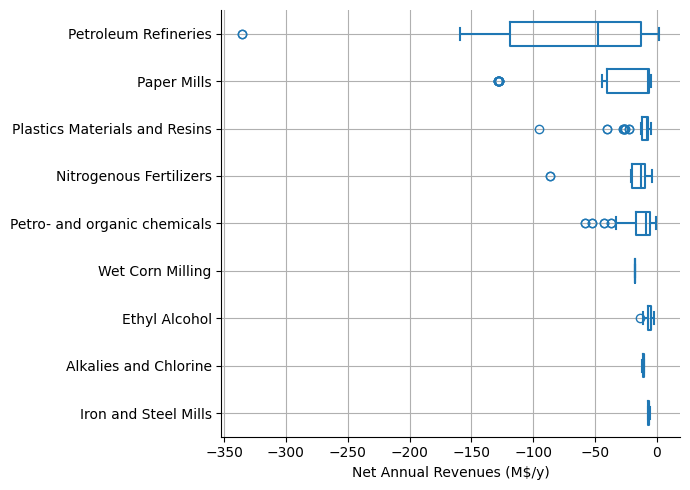

In [129]:
plt.figure(figsize=(7,5))
ax = sns.boxplot(data=no_cogen, y='Industry', x='Net Annual Revenues (M$/y)', fill=False, width=.5)
ax.set_ylabel('')
sns.despine()
ax.grid(True)
plt.tight_layout()
plt.savefig('./results/direct_heat_maxv_nocogen_revenues.png')

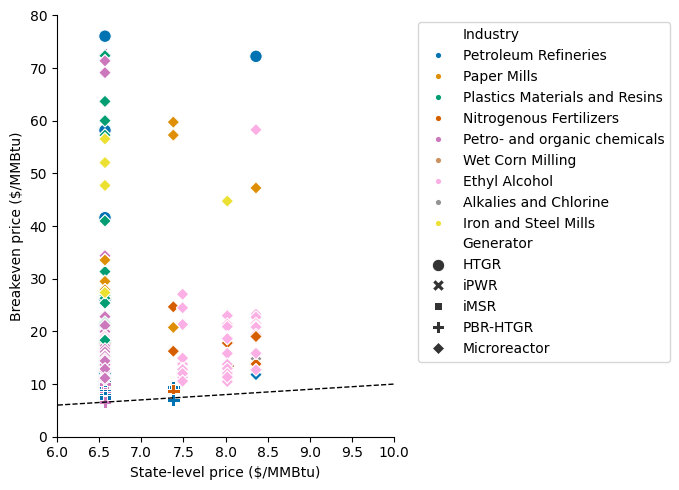

In [130]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(data=no_cogen, x='State-level price ($/MMBtu)',\
                     y='Breakeven price ($/MMBtu)', hue='Industry', palette='colorblind', style='Generator', marker='.', s=80)
ax.set_ylim(0,80)
ax.set_xlim(6,10)
med_x = np.arange(0,50,0.05)
ax.plot(med_x, med_x, color='k', linestyle='--', linewidth=1)
ax.spines[['right', 'top']].set_visible(False)
ax.legend(bbox_to_anchor = (1.05,1), loc='upper left')
save_path = './results/direct_heat_maxv_nocogen.png'
plt.tight_layout()
plt.savefig(save_path)

# Cogeneration plots

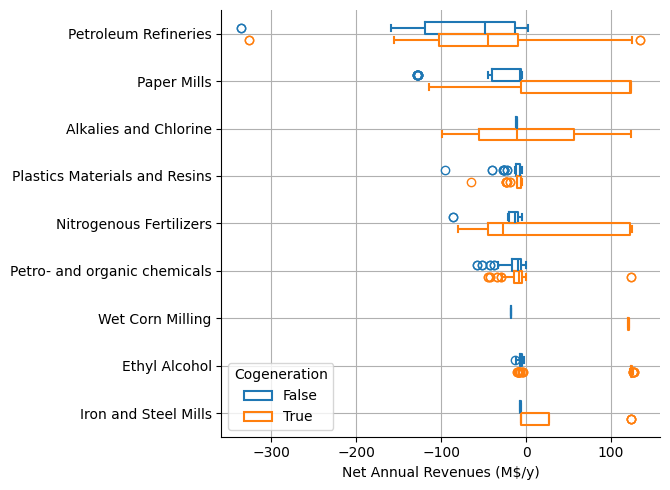

In [132]:
plt.figure(figsize=(7,5))
heat_df.rename(columns={'cogen':'Cogeneration'}, inplace=True)
ax = sns.boxplot(data=heat_df, y='Industry', x='Net Annual Revenues (M$/y)', fill=False, hue='Cogeneration', width=.5)
plt.tight_layout()
ax.set_ylabel('')
sns.despine()
ax.grid(True)
plt.savefig('./results/direct_heat_maxv_comparison_cogen.png')